In [2]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Reduce TF verbosity
import tensorflow as tf
tf.get_logger().setLevel('INFO') # Reduce TF verbosity
tf.compat.v1.disable_eager_execution()

from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from scipy.optimize import fmin_l_bfgs_b

In [3]:
def gram_matrix(img):
    # input shape is (H, W, C), where C = feature maps
    # we first need to convert it to (C, H*W)
    X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))

    # Calcuate the Gram matrix, gram = XX^T / N
    G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
    return G

def style_loss(y, t): 
    return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

def minimize(fn, epochs, batch_shape):

    losses = []
    x = np.random.randn(np.prod(batch_shape))
    for i in range(epochs):
        x, l, _ = fmin_l_bfgs_b(
        func = fn,
        args = batch_shape,
        x0 = x,
        maxfun = 20)
    
        x = np.clip(x, -127, 127)
        print("iter=%s, loss=%s" % (i, l))
        losses.append(l)

    plt.plot(losses)
    plt.title('Loss per iteration')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.show()

    newimg = x.reshape(*batch_shape)
    final_img = unpreprocess(newimg)
    return final_img[0]

def VGG16_AvgPool(shape):
    '''Loads a pre-trained VGG16 and replaces max pooling by average pooling.
    
    Max pooling is too aggressive at throwing away information, whereas average-pooling
    retains more of the original information.
    '''

    vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

    i = tf.keras.Input(shape)
    x = i
    
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            # replace it with average pooling
            x = AveragePooling2D()(x)
        else:
            x = layer(x)

    return Model(i, x)

def unpreprocess(img):
    '''Removes VGG16 preprocessing from the given image.
    '''
    
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    
    return img

def scale_img(x):
    '''Scales the image between [0...1].
    '''
    
    x = x - x.min()
    x = x / x.max()
    
    return x

iter=0, loss=6473.72314453125
iter=1, loss=412.76580810546875
iter=2, loss=76.24845886230469
iter=3, loss=38.91726303100586
iter=4, loss=27.33716583251953
iter=5, loss=20.33607292175293
iter=6, loss=16.318506240844727
iter=7, loss=12.923334121704102
iter=8, loss=11.115816116333008
iter=9, loss=9.690150260925293


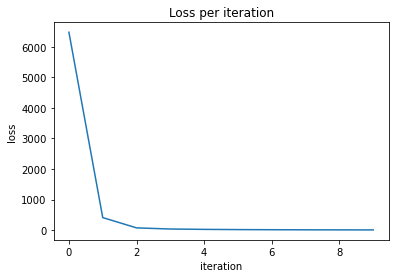

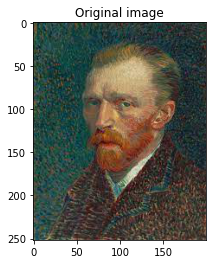

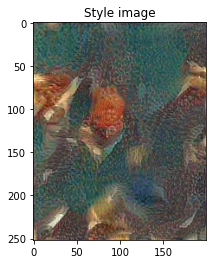

In [5]:
img_path = './large_files/van_gogh.jpeg'

img = image.load_img(img_path)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

batch_shape = x.shape
shape = x.shape[1:]

# let's take the first convolution at each block of convolutions
# to be our target outputs
# remember that you can print out the model summary if you want
vgg = VGG16_AvgPool(shape)

# Note: need to select output at index 1, since outputs at
# index 0 correspond to the original vgg with maxpool
symbolic_conv_outputs = [
    layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')
]

# pick the earlier layers for
# a more "localized" representation
# this is opposed to the content model
# where the later layers represent a more "global" structure
# symbolic_conv_outputs = symbolic_conv_outputs[:2]

# make a big model that outputs multiple layers' outputs
multi_output_model = Model(vgg.input, symbolic_conv_outputs)

# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in multi_output_model.predict(x)]

# calculate the total style loss
loss = 0
for symbolic, actual in zip(symbolic_conv_outputs, style_layers_outputs):
    # gram_matrix() expects a (H, W, C) as input
    loss += style_loss(symbolic[0], actual[0])

grads = K.gradients(loss, multi_output_model.input)

# just like theano.function
get_loss_and_grads = K.function(
    inputs = [multi_output_model.input],
    outputs = [loss] + grads
)

def get_loss_and_grads_wrapper(x_vec, *batch_shape):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)


final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(img)
plt.title('Original image')
plt.show()

plt.imshow(scale_img(final_img))
plt.title('Style image')
plt.show()